In [ ]:
# !pip install pyspellchecker
!pip install transformers
!pip install pymystem3
# !pip install pymorphy2
!pip install datasets
!pip install pyclustering

# !python -m spacy download ru_core_news_sm

In [ ]:
from datasets import load_dataset
import json
def get_dataset_dict():
  _dataset = load_dataset('abobster/rosatom-clustering')
  return json.loads(_dataset['train']['text'][0])

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
import numpy as np


nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('all')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!

True

#Функции

In [ ]:
import re
import nltk
import pymystem3
from nltk.corpus import stopwords
from string import punctuation

nltk.download("stopwords")
russian_stopwords = set(stopwords.words("russian"))
#Create lemmatizer and stopwords list
mystem = pymystem3.mystem.Mystem()

def prep_text(data_texts):
  documents = []

  stemmer = WordNetLemmatizer()

  for sen in range(0, len(data_texts)):
      # Remove all the special characters
      document = re.sub(r'\W', ' ', str(data_texts[sen]))

      # remove all single characters
      document = re.sub(r'\s+[a-zA-Zа-яА-Я0-9]\s+', ' ', document)

      # Remove single characters from the start
      document = re.sub(r'\^[a-zA-Zа-яА-Я0-9]\s+', ' ', document)

      # Substituting multiple spaces with single space
      document = re.sub(r'\s+', ' ', document, flags=re.I)

      document = re.sub("ё", "е", document.lower())

      # Removing prefixed 'b'
      document = re.sub(r'^b\s+', '', document)

      # Converting to Lowercase
      document = document.lower()

      # Lemmatization
      tokens = mystem.lemmatize(document)
      new_tokens = list()
      for token in tokens:
        if token not in russian_stopwords and token != " " :
          if token.strip() not in punctuation:
            #if len(token) > 2:
            new_tokens.append(token)
      document = ' '.join(new_tokens)

      documents.append(document)

  return documents

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Загрузка данных

In [ ]:
data = get_dataset_dict()

In [ ]:
 data["24268"]

{'question': 'Что ожидаете от сегодняшнего дня',
 'id': 24268,
 'answers': [{'answer': 'бодрое',
   'count': 1,
   'cluster': 'бодрое',
   'sentiment': 'positives'},
  {'answer': 'больше знакомств!',
   'count': 1,
   'cluster': 'знакомства',
   'sentiment': 'neutrals',
   'corrected': 'больше знакомств'},
  {'answer': 'знакомства',
   'count': 3,
   'cluster': 'знакомства',
   'sentiment': 'neutrals'},
  {'answer': 'знакомство с интересными людьм',
   'count': 1,
   'cluster': 'знакомства',
   'sentiment': 'positives',
   'corrected': 'знакомство с интересными людьми'},
  {'answer': 'интересных знакомств',
   'count': 1,
   'cluster': 'знакомства',
   'sentiment': 'positives'},
  {'answer': 'контакты',
   'count': 1,
   'cluster': 'новые контакты',
   'sentiment': 'neutrals'},
  {'answer': 'личное знакомство',
   'count': 1,
   'cluster': 'знакомства',
   'sentiment': 'neutrals'},
  {'answer': 'нетворкинг',
   'count': 3,
   'cluster': 'новые контакты',
   'sentiment': 'positives',
  

In [ ]:
answers = [ans["answer"] for ans in data["24268"]["answers"]]
true_clusters = [ans["cluster"] for ans in data["24268"]["answers"]] # 27855

In [ ]:
prepared_texts = prep_text(answers)

#RuBert

In [ ]:
import torch
from transformers import BertModel, BertTokenizer

# Загрузка предобученной модели RuBERT
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

def get_rubert_text_embedding(text):
  # Токенизация текста
  x_inputs = list()
  tokens = tokenizer.tokenize(text)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  # Добавление токена начала и конца последовательности
  token_ids = [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id]
  x_inputs.append(token_ids)

  # Преобразование в тензор
  input_ids = torch.tensor(x_inputs)

  # Получение эмбеддинга предложения
  with torch.no_grad():
      outputs = bert_model(input_ids)
      sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

  # Вывод эмбеддинга предложения
  return sentence_embedding

#Кластеризация

In [ ]:
#bert_embeddings = [get_text_embedding(txt).numpy() for txt in prepared_texts]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

def determine_k(embeddings):
    k_min = 10

    clusters = [x for x in range(2, k_min * 3)]

    metrics = []

    for i in clusters:
        print(i, '/', len(clusters))
        metrics.append((KMeans(n_clusters=i).fit(embeddings)).inertia_)

    k = elbow(k_min, clusters, metrics)
    return k

def elbow(k_min, clusters, metrics):
    score = []

    for i in range(k_min, clusters[-3]):
        y1 = np.array(metrics)[:i + 1]
        y2 = np.array(metrics)[i:]

        df1 = pd.DataFrame({'x': clusters[:i + 1], 'y': y1})
        df2 = pd.DataFrame({'x': clusters[i:], 'y': y2})

        reg1 = LinearRegression().fit(np.asarray(df1.x).reshape(-1, 1), df1.y)
        reg2 = LinearRegression().fit(np.asarray(df2.x).reshape(-1, 1), df2.y)

        y1_pred = reg1.predict(np.asarray(df1.x).reshape(-1, 1))
        y2_pred = reg2.predict(np.asarray(df2.x).reshape(-1, 1))

        score.append(mean_squared_error(y1, y1_pred) + mean_squared_error(y2, y2_pred))

    return np.argmin(score) + k_min

In [ ]:
answer_vectorizer = TfidfVectorizer()
answer_vectorizer.fit(prepared_texts)
answer_vects = answer_vectorizer.transform(prepared_texts).toarray()

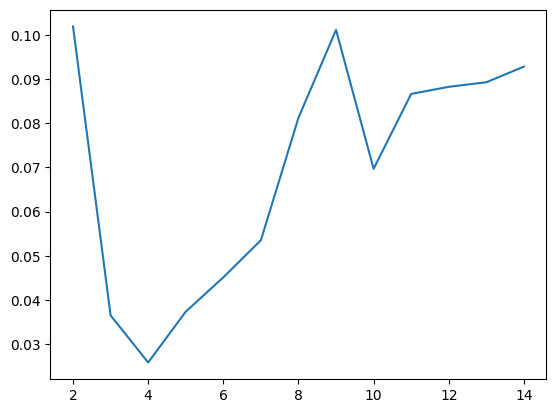

In [ ]:
import matplotlib.pyplot as plt

k_min = 15
clusters = [x for x in range(2, k_min)]
metrics = []
for i in clusters:
    kmeans = KMeans(n_clusters = i, random_state = 42, n_init='auto')
    kmeans.fit(embeddings)
    sil_score = silhouette_score(embeddings, kmeans.labels_, metric='euclidean')
    metrics.append(sil_score)

plt.plot(clusters, metrics)

In [ ]:
!wget https://rusvectores.org/static/models/rusvectores4/RNC/ruscorpora_upos_skipgram_300_5_2018.vec.gz

--2023-09-09 19:01:52--  https://rusvectores.org/static/models/rusvectores4/RNC/ruscorpora_upos_skipgram_300_5_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 172.104.228.108
Connecting to rusvectores.org (rusvectores.org)|172.104.228.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199864398 (191M) [application/x-gzip]
Saving to: ‘ruscorpora_upos_skipgram_300_5_2018.vec.gz’

ruscorpora_upos_ski 100%[===================>] 190.61M  18.9MB/s    in 12s     

2023-09-09 19:02:04 (16.3 MB/s) - ‘ruscorpora_upos_skipgram_300_5_2018.vec.gz’ saved [199864398/199864398]



In [ ]:
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser

words_lists = [ans.split() for ans in prepared_texts]

model = KeyedVectors.load_word2vec_format('ruscorpora_upos_skipgram_300_5_2018.vec.gz', binary=False)


In [ ]:
for n in model.most_similar(positive=['контакт_NOUN']):
    print( n[0], n[1])

np.mean([model[word] for word in words_lists], axis=0)

общение_NOUN 0.6105278730392456
соприкосновение_NOUN 0.5869833827018738
контакт_PROPN 0.5580770969390869
связь_NOUN 0.5573739409446716
взаимодействие_NOUN 0.5526005029678345
контакты_NOUN 0.5353706479072571
сношение_NOUN 0.5326734781265259
контактировать_VERB 0.5297574996948242
взаимопонимание_NOUN 0.5048564076423645
взаимоотношение_NOUN 0.4884534478187561


KeyError: ignored

In [ ]:
w2v_model.wv.most_similar(positive=["контакт"])

In [ ]:
determine_k(answer_vects)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
n_clusters = 12

kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init='auto', )
kmeans.fit(answer_vects)

KMeans(n_clusters=12, n_init='auto', random_state=42)

In [ ]:
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(bert_embeddings)

In [ ]:
cluster_num = 1

labels = gmm.predict(bert_embeddings)
 #labels = kmeans.labels_
for cluster_n in range(n_clusters):
  print(cluster_n)
  for i in range(len(answers)):
    if labels[i] == cluster_n:
      print(answers[i])
  print()

NameError: ignored

In [ ]:
prepared_texts

['бодрый',
 'знакомство',
 'знакомство',
 'знакомство интересный людьма',
 'интересный знакомство',
 'контакт',
 'личный знакомство',
 'нетворкинг',
 'новый деловой контакт',
 'новый знакомство',
 'новый контакт',
 'новый контакт знакомство',
 'новый отношение',
 'новый связь',
 'новый друг',
 'новый знакомство',
 'познакомиться',
 'познакомиться',
 'полезный контакт',
 'полезный знакомство',
 'установка контакт',
 'вакансия',
 'вдохновение',
 'веселие',
 'проводить время',
 'вкусняшка',
 'еда',
 'ехать',
 'встреча друг',
 'знакомство обменяться опыт',
 'знание',
 'знание',
 'знание',
 'информация',
 'информация',
 'новый актуальный знание',
 'новый знание',
 'новый знание возможность',
 'новый знание',
 'познавательный информация',
 'полезный информация',
 'полезный',
 'узнавать новое',
 'знание знакомство',
 'изменение',
 'иной взгляд',
 'инсайт',
 'инсайт',
 'инсайт',
 'интересный информация',
 'интересность',
 'интересный идея',
 'интересный идея',
 'новый идея',
 'новый идея',
 'и

['#000000', '#155555', '#2aaaaa', '#3fffff', '#555554', '#6aaaa9', '#7ffffe', '#955553', '#aaaaa8', '#bffffd', '#d55552', '#eaaaa7']


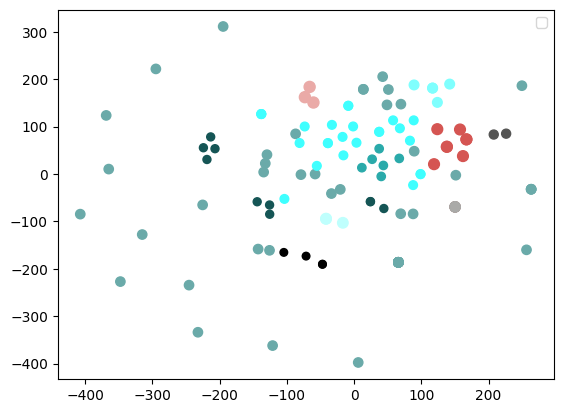

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Определяем модель и скорость обучения
model = TSNE(random_state=42)

# Обучаем модель
transformed = model.fit_transform(np.array(answer_vects))

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

colors = ["#" + hex(((0xFFFFFF) // n_clusters) * i ).replace("0x", "").zfill(6)
        for i in range(n_clusters)]

print(colors)
color_points = [colors[i] for i in kmeans.labels_]

plt.scatter(x_axis, y_axis, c=color_points, s=[30*((i/n_clusters)*1.2 + 1) for i in kmeans.labels_])
plt.legend()
plt.show()

In [ ]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


#user_function = lambda point1, point2: euclidean_distance(point1, point2)
#metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
metric = distance_metric(type_metric.EUCLIDEAN)

# bert_embeddings
# create K-Means algorithm with specific distance metric
start_centers = kmeans_plusplus_initializer(answer_vects, 10).initialize()
kmeans_instance = kmeans(answer_vects, start_centers, metric=metric)

# run cluster analysis and obtain results
kmeans_instance.process()
pycl_clusters = kmeans_instance.get_clusters()

In [ ]:
 #labels = kmeans.labels_
for i, cluster in enumerate(pycl_clusters):
  print(i)
  for j in cluster:
    print(answers[j], "processed:" ,prepared_texts[j])
  print()

In [ ]:

sum_answers = list()
for i, cluster in enumerate(pycl_clusters):
  cluster_answers = list()
  for ans in cluster:
    cluster_answers.append(prepared_texts[ans])
  sum_answers.append(" ".join(cluster_answers))


vectorizer = TfidfVectorizer()
vectorizer.fit(sum_answers)
tfidf_vects = vectorizer.transform(sum_answers).toarray()
feature_names = vectorizer.get_feature_names_out()

for i, cluster in enumerate(pycl_clusters):
  features = list(zip(feature_names, tfidf_vects[i]))
  print(i)
  print(sorted(features, key=lambda s: s[1], reverse=True)[:5])

0
[('интересный', 0.42400370193300213), ('знакомство', 0.3153440558146779), ('информация', 0.3028597870950015), ('полезный', 0.3028597870950015), ('опыт', 0.2422878296760012)]
1
[('понимать', 0.8944271909999159), ('легочеть', 0.4472135954999579), ('it', 0.0), ('актуальный', 0.0), ('ап', 0.0)]
2
[('еда', 0.6324555320336759), ('мерч', 0.6324555320336759), ('бодрый', 0.31622776601683794), ('поспать', 0.31622776601683794), ('it', 0.0)]
3
[('знание', 0.9340172003684366), ('новый', 0.30873605932325765), ('актуальный', 0.1037796889298263), ('возможность', 0.08822221690050341), ('счастие', 0.08822221690050341)]
4
[('кайф', 1.0), ('it', 0.0), ('актуальный', 0.0), ('ап', 0.0), ('бодрый', 0.0)]
5
[('тренд', 0.7606980520365577), ('время', 0.25356601734551926), ('ита', 0.25356601734551926), ('кругозор', 0.25356601734551926), ('проводить', 0.25356601734551926)]
6
[('новый', 0.936457534164337), ('возможность', 0.16055726022723077), ('контакт', 0.16055726022723077), ('знакомство', 0.14046863012465055)

In [ ]:
# сохранение собственного tfidf
from collections import Counter

all_words = Counter()
clusters_counters = list()
sum_answers = list()
for i, cluster in enumerate(pycl_clusters):
  cluster_answers = list()
  cluster_counter = Counter()

  for ans in cluster:
    cluster_answers.append(prepared_texts[ans])
    cluster_counter.update(prepared_texts[ans].split())
    all_words.update(cluster_counter)

  clusters_counters.append(cluster_counter)
  all_words.update(cluster_counter)

for i, cluster in enumerate(pycl_clusters):
  words_importance = [(word, clusters_counters[i][word] / all_words[word]) for word in clusters_counters[i]]
  print(sorted(words_importance, key=lambda s: s[1], reverse=True)[:5])
print()

In [ ]:
!git clone https://github.com/atefm/pDMM
%cd pDMM
!python setup.py install

In [ ]:
import os, sys
sys.path.append(os.getcwd())
import pdmm
pdmm_data = [ans.split() for ans in prepared_texts]
corpus = pdmm.Corpus.from_iterable_of_word_lists(pdmm_data)
model = pdmm.GibbsSamplingDMM(corpus)
model.randomly_initialise_topic_assignment()
model.inference(number_of_iterations=100)

model.document_topic_assignments

for cluster_n in range(model.number_of_topics):
  print(cluster_n)
  for i in range(len(answers)):
    if model.document_topic_assignments[i] == cluster_n:
      print(answers[i])
  print()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer.fit(prepared_texts)

sorted(vectorizer.vocabulary_.items(), key=lambda s: s[1], reverse=True)

sorted(tdidf_obj, key=lambda s: s[1], reverse=True)


#SpreaderHat

In [ ]:
from pyclustering.cluster.kmeans import kmeans as pycl_kmeans
from pyclustering.cluster.elbow import elbow as pycl_elbow
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.hsyncnet import hsyncnet




class SpreaderHat:
    def __init__(self, n_clusters="auto"):
        self.n_clusters = n_clusters
        self.kmeans_instance = None

    def train(self, train_data):
        if type(self.n_clusters) != int:
            elbow_instance = pycl_elbow(train_data, 2, len(train_data)//4)
            elbow_instance.process()
            self.n_clusters = elbow_instance.get_amount()

        metric = distance_metric(type_metric.EUCLIDEAN)
        start_centers = kmeans_plusplus_initializer(train_data, self.n_clusters).initialize()
        self.model = pycl_kmeans(train_data, start_centers, metric=metric)
        self.model.process()
        #self.model = hsyncnet(train_data, self.n_clusters, ccore = True)
        # run cluster analysis and output dynamic of the network
        #(time, dynamic) =  self.model.process()

    def get_clusters(self):
        return self.model.get_clusters()

    def get_most_importance_cluster_words(self, prepared_texts, top=5):
        sum_answers = list()
        pycl_clusters = self.model.get_clusters()
        for i, cluster in enumerate(pycl_clusters):
            cluster_answers = list()
            for ans in cluster:
                cluster_answers.append(prepared_texts[ans])
            sum_answers.append(" ".join(cluster_answers))

        vectorizer = TfidfVectorizer()
        vectorizer.fit(sum_answers)
        tfidf_vects = vectorizer.transform(sum_answers).toarray()
        feature_names = vectorizer.get_feature_names_out()

        result = dict()
        for i, cluster in enumerate(pycl_clusters):
            features = list(zip(feature_names, tfidf_vects[i]))
            features.sort(key=lambda s: s[1], reverse=True)
            top_features = features[:top]
            result[i] = {k:v for k,v in top_features}

        return result


#TextPreprocessor

In [ ]:
import re
import nltk
import pymystem3
from nltk.corpus import stopwords
from string import punctuation

# from profanity_filter import ProfanityFilter


class BadWordChecker:
    def __init__(self):
        !gdown 1XeuHQ13N4XYBBH5naE5riUlPVU-KczAf
        with open("bad_words.txt", "r") as f:
            self.words = set([i.replace("\n", "") for i in f.readlines()])

    def is_bad_word(self, word):
        return word in self.words

    def is_bad_text(self, text):
        return len(set(text) & self.words) > 0


class EmojiConverter:
    def __init__(self):
        !gdown 1GyWCwQyyWUW_Jt9jh3ZXN0xQkhgWQ39A
        self.d = dict()
        with open("emoji_dataset.txt", "r") as f:
            f = f.readlines()[0].split("@")
            for i in f:
                a, b = i.split(";")
                self.d[a] = b

    def convert_string(self, s):
        for i in self.d.keys():
            s = s.replace(i, f" {self.d[i]} ")
        return s


# stemmer = WordNetLemmatizer()

# Create lemmatizer and stopwords list
nltk.download("stopwords")
russian_stopwords = set(stopwords.words("russian"))
mystem = pymystem3.mystem.Mystem()
emoji_converter = EmojiConverter()
bad_word_checker = BadWordChecker()
# pf = ProfanityFilter(languages=["ru", "en"])


class TextPreprocessor:
    def __init__(self, texts):
        self.raw_documents = texts
        self.prepared_texts = ""

    def lemmatize_text(self, document):
        tokens = mystem.lemmatize(document)
        new_tokens = list()
        for token in tokens:
            if token not in russian_stopwords and token != " ":
                if token.strip() not in punctuation:
                    # if len(token) > 2:
                    new_tokens.append(token)
        document = " ".join(new_tokens)

        return document

    def is_bad_text(self, text):
        return bad_word_checker.is_bad_text(text)

    def clean_texts(
        self,
        texts=None,
        lemmatization=True,
        emoji_decode=True,
        only_censored_texts=True,
    ):
        """
        Remove all the special characters
        Remove all single characters
        Remove single characters from the start
        Substituting multiple spaces with single space
        Replace the "ё" with an "е"
        Converting to lowercase
        and other optional functions
        """

        only_censored_texts = lemmatization & only_censored_texts

        if texts is None:
            texts = self.raw_documents
        documents = []

        for sen in range(0, len(texts)):
            document = str(texts[sen])

            if emoji_decode:
                document = emoji_converter.convert_string(document)
            # Remove all the special characters
            document = re.sub(r"\W", " ", document)
            # remove all single characters
            document = re.sub(r"\s+[a-zA-Zа-яА-Я0-9]\s+", " ", document)
            # Remove single characters from the start
            document = re.sub(r"\^[a-zA-Zа-яА-Я0-9]\s+", " ", document)
            # Substituting multiple spaces with single space
            document = re.sub(r"\s+", " ", document, flags=re.I)
            document = re.sub("ё", "е", document.lower())
            # Removing prefixed 'b'
            document = re.sub(r"^b\s+", "", document)
            # Converting to lowercase
            document = document.lower()

            # Lemmatization
            if lemmatization:
                document = self.lemmatize_text(document)

                if only_censored_texts:
                    if self.is_bad_text(document):
                        continue
            documents.append(document)
        self.prepared_texts = documents
        return documents


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Downloading...
From: https://drive.google.com/uc?id=1GyWCwQyyWUW_Jt9jh3ZXN0xQkhgWQ39A
To: /content/emoji_dataset.txt
100% 235k/235k [00:00<00:00, 37.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XeuHQ13N4XYBBH5naE5riUlPVU-KczAf
To: /content/bad_words.txt
100% 92.5k/92.5k [00:00<00:00, 69.4MB/s]


In [ ]:
print(*russian_stopwords, sep="\n")

так
тоже
этот
во
моя
была
здесь
них
эти
как
чтоб
под
их
ни
иногда
бы
теперь
о
для
ней
его
или
тебя
то
между
вам
же
вы
чуть
она
всех
будто
этого
когда
ей
от
три
нельзя
может
они
этой
лучше
какой
том
быть
мы
сам
два
много
хорошо
об
по
чего
зачем
куда
с
сейчас
впрочем
мне
к
тот
а
ее
в
нее
после
где
перед
что
без
свою
ним
потому
при
были
будет
уж
больше
над
было
ведь
и
я
ничего
там
тут
да
нибудь
вот
опять
себе
до
нет
него
со
ты
можно
хоть
такой
уже
на
почти
ну
только
никогда
у
даже
другой
ж
ему
все
потом
еще
есть
но
вдруг
чтобы
через
нас
он
раз
им
если
всегда
чем
эту
ли
про
был
конечно
тогда
того
вас
надо
совсем
всю
не
разве
всего
меня
один
тем
более
из
мой
себя
кто
какая
за
этом
наконец


In [ ]:
!gdown 1XeuHQ13N4XYBBH5naE5riUlPVU-KczAf

Downloading...
From: https://drive.google.com/uc?id=1XeuHQ13N4XYBBH5naE5riUlPVU-KczAf
To: /content/bad_words.txt
100% 92.5k/92.5k [00:00<00:00, 67.4MB/s]


#utils

In [ ]:
def determine_k(embeddings, k_min=10):
    clusters = [x for x in range(2, k_min * 3)]

    metrics = []

    for i in clusters:
        print(i, '/', len(clusters))
        metrics.append((KMeans(n_clusters=i).fit(embeddings)).inertia_)

    k = elbow(k_min, clusters, metrics)
    return k

def elbow(k_min, clusters, metrics):
    score = []

    for i in range(k_min, clusters[-3]):
        y1 = np.array(metrics)[:i + 1]
        y2 = np.array(metrics)[i:]

        df1 = pd.DataFrame({'x': clusters[:i + 1], 'y': y1})
        df2 = pd.DataFrame({'x': clusters[i:], 'y': y2})

        reg1 = LinearRegression().fit(np.asarray(df1.x).reshape(-1, 1), df1.y)
        reg2 = LinearRegression().fit(np.asarray(df2.x).reshape(-1, 1), df2.y)

        y1_pred = reg1.predict(np.asarray(df1.x).reshape(-1, 1))
        y2_pred = reg2.predict(np.asarray(df2.x).reshape(-1, 1))

        score.append(mean_squared_error(y1, y1_pred) + mean_squared_error(y2, y2_pred))

    return np.argmin(score) + k_min

#Экперименты

In [ ]:
#!wget https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz
!wget https://rusvectores.org/static/models/rusvectores4/RNC/ruscorpora_upos_skipgram_300_5_2018.vec.gz

--2023-09-10 06:33:07--  https://rusvectores.org/static/models/rusvectores4/RNC/ruscorpora_upos_skipgram_300_5_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 172.104.228.108
Connecting to rusvectores.org (rusvectores.org)|172.104.228.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199864398 (191M) [application/x-gzip]
Saving to: ‘ruscorpora_upos_skipgram_300_5_2018.vec.gz.1’

ruscorpora_upos_ski 100%[===================>] 190.61M  13.4MB/s    in 17s     

2023-09-10 06:33:25 (11.1 MB/s) - ‘ruscorpora_upos_skipgram_300_5_2018.vec.gz.1’ saved [199864398/199864398]



In [ ]:
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser

words_lists = [ans.split() for ans in prepared_texts]

model = KeyedVectors.load_word2vec_format('ruscorpora_upos_skipgram_300_5_2018.vec.gz', binary=False)

def get_tfidf_embeddings(texts):
  embeddings_vectorizer = TfidfVectorizer()
  embeddings_vectorizer.fit(texts)
  embeddings_tfidf = embeddings_vectorizer.transform(texts).toarray()
  return embeddings_tfidf

In [ ]:

mystem_tags_to_upos = {
    "A": "ADJ",
    "ADV": "ADV",
    "ADVPRO": "ADV",
    "ANUM": "ADJ",
    "APRO": "DET",
    "COM": "ADJ",
    "CONJ": "SCONJ",
    "INTJ": "INTJ",
    "NONLEX": "X",
    "NUM": "NUM",
    "PART": "PART",
    "PR": "ADP",
    "S": "NOUN",
    "SPRO": "PRON",
    "UNKN": "X",
    "V": "VERB",
}
# np.mean([model[word] for word in words_lists], axis=0)
import numpy


zarray = numpy.zeros(300)

def get_word2vec_embeddings(document):
    tokens = mystem.analyze(document)
    new_tokens = list()
    document_vec = list()

    for token in tokens:
        if token["text"].strip() == "":
            continue
        if not token["analysis"]:
            continue

        # print(token)
        lemma = token["analysis"][0]["lex"]
        part_speech = token["analysis"][0]["gr"].split(",")[0].replace("=", "")
        part_speech = re.match(r"^[A-Z]*", part_speech).group(0)
        upos = mystem_tags_to_upos[part_speech]
        word = f"{lemma}_{upos}"

        try:
            word_vec = model[word]
        except KeyError:
            document_vec.append(zarray)
            print(word)
            continue

        if lemma not in russian_stopwords and lemma != " ":
            if lemma.strip() not in punctuation:
                document_vec.append(word_vec)
                new_tokens.append(lemma)

    return np.mean(document_vec, axis=0)



#lemmatize_word2vec("катается со смеху  испытывает облегчение привет")


In [ ]:
import os, sys
sys.path.append(os.getcwd())

In [ ]:
text_preprocessor = TextPreprocessor(answers)
prepared_texts = text_preprocessor.clean_texts()

spreader_hat = SpreaderHat(n_clusters="auto")
embeddings = [get_word2vec_embeddings(ans) for ans in prepared_texts]
#embeddings = get_tfidf_embeddings(prepared_texts)
#embeddings = [get_rubert_text_embedding(txt).numpy() for txt in prepared_texts] #get_tfidf_embeddings(prepared_texts)

spreader_hat.train(embeddings)

людьма_NOUN
нетворкинг_NOUN
вкусняшка_NOUN
иной_DET
касперская_NOUN
конструктив_NOUN
конструктив_NOUN
легочеть_VERB
мерч_NOUN
мерч_NOUN
ита_NOUN
професионал_NOUN
самый_DET
14


In [ ]:
!pip freeze >> requirements.txt

In [ ]:
prepared_texts

In [ ]:
spreader_hat.get_most_importance_cluster_words(prepared_texts, top=10)

{0: {'инсайт': 0.9150291797799853,
  'мотивация': 0.3050097265933284,
  'тренд': 0.2639898991147776,
  'it': 0.0,
  'актуальный': 0.0,
  'ап': 0.0,
  'бодрый': 0.0,
  'вакансия': 0.0,
  'вдохновение': 0.0,
  'веселие': 0.0},
 1: {'бодрый': 1.0,
  'it': 0.0,
  'актуальный': 0.0,
  'ап': 0.0,
  'вакансия': 0.0,
  'вдохновение': 0.0,
  'веселие': 0.0,
  'взгляд': 0.0,
  'вкусняшка': 0.0,
  'возможность': 0.0},
 2: {'познакомиться': 1.0,
  'it': 0.0,
  'актуальный': 0.0,
  'ап': 0.0,
  'бодрый': 0.0,
  'вакансия': 0.0,
  'вдохновение': 0.0,
  'веселие': 0.0,
  'взгляд': 0.0,
  'вкусняшка': 0.0},
 3: {'вакансия': 1.0,
  'it': 0.0,
  'актуальный': 0.0,
  'ап': 0.0,
  'бодрый': 0.0,
  'вдохновение': 0.0,
  'веселие': 0.0,
  'взгляд': 0.0,
  'вкусняшка': 0.0,
  'возможность': 0.0},
 4: {'информация': 0.9589515300689176,
  'познавательный': 0.19179030601378352,
  'интересный': 0.14769638028337229,
  'полезный': 0.14769638028337229,
  'it': 0.0,
  'актуальный': 0.0,
  'ап': 0.0,
  'бодрый': 0.0,

In [ ]:
#spreader_hat.get_most_importance_cluster_words()
pycl_clusters = spreader_hat.get_clusters()

kmean_labeles = list()
for i, cluster in enumerate(pycl_clusters):
  for j in cluster:
      kmean_labeles.append((j, i))
kmean_labeles.sort(key=lambda s: s[0])
kmean_labeles = list(map(lambda s:s[1], kmean_labeles))

In [ ]:
# new_clusters_embeddings = dict()

# for i, cluster in enumerate(pycl_clusters):
#   new_clusters_embeddings[i] = list()
#   for j in cluster:
#     new_clusters_embeddings[i].append(embeddings[j])

In [ ]:
df = pd.DataFrame(data = {"index_cluster" : kmean_labeles, "embeddings" : embeddings})
df.to_csv("embeddings.csv")

In [ ]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(embeddings, kmean_labeles, metric='euclidean')
sil_score

0.10239004792479556

In [ ]:
true_clusters

In [ ]:
len(set(kmean_labeles)), len(set(true_clusters))

(0, 60)

In [ ]:
from sklearn.metrics.cluster import pair_confusion_matrix


#true_clusters
confusion_matrix = pair_confusion_matrix(kmean_labeles, true_clusters)

TP = confusion_matrix[0][0]
FP = confusion_matrix[1][0]
TN = confusion_matrix[0][1]
FN = confusion_matrix[1][1]
recall = TP / (FN + TP)
precision = TP / (TP + FP)
f1_score = 2 * 1/(1/recall + 1/precision)

print(TN, FP, FN, TP)
print(f1_score, recall, precision)

164 2674 232 11936
0.8914780790200911 0.9809335963182118 0.816974674880219


#Word2vec

['#000000', '#199999', '#333332', '#4ccccb', '#666664', '#7ffffd', '#999996', '#b3332f', '#ccccc8', '#e66661']


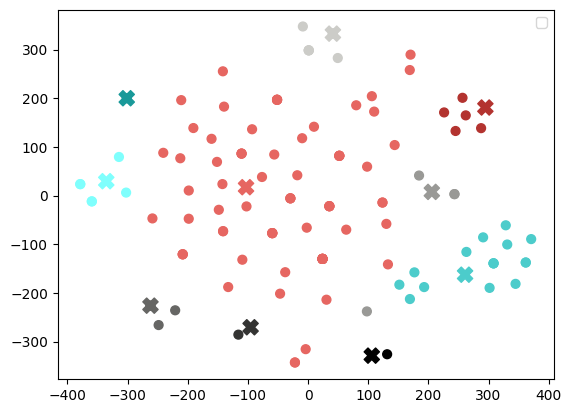

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_clusters = len(pycl_clusters)

# Определяем модель и скорость обучения
model = TSNE(random_state=42)

centeres = spreader_hat.kmeans_instance.get_centers()
all_points = np.concatenate([np.array(embeddings), centeres])

# Обучаем модель
transformed = model.fit_transform(all_points)

# Представляем результат в двумерных координатах
xc_axis = transformed[len(words_lists):, 0]
yc_axis = transformed[len(words_lists):, 1]

x_axis = transformed[:len(words_lists), 0]
y_axis = transformed[:len(words_lists), 1]

colors = ["#" + hex(((0xFFFFFF) // n_clusters) * i ).replace("0x", "").zfill(6)
        for i in range(n_clusters)]

print(colors)
color_points = [colors[cls] for cls in kmean_labeles]
#sizes = [30*((i/n_clusters)*1.2 + 1) for i in kmeans.labels_]
plt.scatter(x_axis, y_axis, c=color_points, s=40)

plt.scatter(xc_axis, yc_axis, c=[colors[i] for i in range(len(centeres))], s=120,
            marker="X")

plt.legend()
plt.show()



In [ ]:
#!wget https://rusvectores.org/static/models/rusvectores4/RNC/ruscorpora_upos_skipgram_300_5_2018.vec.gz
!wget https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz

--2023-09-09 20:35:25--  https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 172.104.228.108
Connecting to rusvectores.org (rusvectores.org)|172.104.228.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394697055 (376M) [application/x-gzip]
Saving to: ‘ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz’

ruwikiruscorpora_up 100%[===================>] 376.41M  19.2MB/s    in 25s     

2023-09-09 20:35:51 (15.2 MB/s) - ‘ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz’ saved [394697055/394697055]



In [ ]:
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser

words_lists = [ans.split() for ans in prepared_texts]

model = KeyedVectors.load_word2vec_format('ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz', binary=False)

In [ ]:
mystem_tags_to_upos = {
    "A": "ADJ",
    "ADV": "ADV",
    "ADVPRO": "ADV",
    "ANUM": "ADJ",
    "APRO": "DET",
    "COM": "ADJ",
    "CONJ": "SCONJ",
    "INTJ": "INTJ",
    "NONLEX": "X",
    "NUM": "NUM",
    "PART": "PART",
    "PR": "ADP",
    "S": "NOUN",
    "SPRO": "PRON",
    "UNKN": "X",
    "V": "VERB",
}
# np.mean([model[word] for word in words_lists], axis=0)
import numpy


zarray = numpy.zeros(300)

def get_word2vec_embeddings(document):
    tokens = mystem.analyze(document)
    new_tokens = list()
    document_vec = list()

    for token in tokens:
        if token["text"].strip() == "":
            continue
        if not token["analysis"]:
            continue

        # print(token)
        lemma = token["analysis"][0]["lex"]
        part_speech = token["analysis"][0]["gr"].split(",")[0].replace("=", "")
        part_speech = re.match(r"^[A-Z]*", part_speech).group(0)
        upos = mystem_tags_to_upos[part_speech]
        word = f"{lemma}_{upos}"

        try:
            word_vec = model[word]
        except KeyError:
            document_vec.append(zarray)
            print(word)
            continue

        if lemma not in russian_stopwords and lemma != " ":
            if lemma.strip() not in punctuation:
                document_vec.append(word_vec)
                new_tokens.append(lemma)

    return np.mean(document_vec, axis=0)



#lemmatize_word2vec("катается со смеху  испытывает облегчение привет")


In [ ]:
words_lists

In [ ]:

em_conv = EmojiConverter()
em_conv.convert_string("🤣😌привет")

Downloading...
From: https://drive.google.com/uc?id=1GyWCwQyyWUW_Jt9jh3ZXN0xQkhgWQ39A
To: /content/emoji_dataset.txt
100% 235k/235k [00:00<00:00, 64.1MB/s]


' катается со смеху  испытывает облегчение привет'

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Определяем модель и скорость обучения
model = TSNE(random_state=42)

# Обучаем модель
transformed = model.fit_transform(np.array(answer_vects))

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

colors = ["#" + hex(((0xFFFFFF) // n_clusters) * i ).replace("0x", "").zfill(6)
        for i in range(n_clusters)]

print(colors)
color_points = [colors[i] for i in kmeans.labels_]

plt.scatter(x_axis, y_axis, c=color_points, s=[30*((i/n_clusters)*1.2 + 1) for i in kmeans.labels_])
plt.legend()
plt.show()

In [ ]:
pycl_clusters = spreader_hat.get_clusters()

for i, cluster in enumerate(pycl_clusters):
  print(i)
  for j in cluster:
    print(answers[j])
  print()

0
левел ап

1
бодрое

2
кайф

3
больше знакомств!
знакомства
знакомство с интересными людьм
интересных знакомств
личное знакомство
новые знакомства
новых друзей
новых знакомств
познакомиться
познакомиться с
полезных знакомств
знакомства обменяться опытом
интересные коммуникации
общение
общение в живую
общения

4
узнать новое
нового
новое
что-то новое

5
вдохновение
инсайт
инсайты
много инсайтов
просветления
чуда

6
веселье
преисполниться
счастье
счастья знаний

7
информацию
информация
познавательную информацию
полезная информация
интересной информации

8
знаний
знания
знания
новые актуальные знания
новые знания
новые знания и возможности
новых знаний
знания и знакомства

9
контакты
нетворкинг
новые деловые контакты
новые контакты
новые контакты и знакомства
новые отношения
новые связи
полезные контакты
установка контактов
вакансию
хорошо провести время
вкусняшек:*
еда
еду
встречи с друзьями
полезного
изменения
иной взгляд
интересности
интересные идеи
интересных идей
новые идеи
новых ид

#Экперименты с лемматизацией

In [ ]:
import spacy
import ru_core_news_sm

spacy_model = ru_core_news_sm.load()

In [ ]:
import pymystem3

mystem = pymystem3.mystem.Mystem()

In [ ]:
text = """для дит - сбаланс-анный бюд"""
tokens = mystem.lemmatize(text.lower())
text

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker(language="ru")


print(spell.correction("аспирантура"))

In [ ]:
doc = spacy_model(text)

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_)

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("russian")
stems = [stemmer.stem(word) for word in text.split()]
stems

In [ ]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

In [ ]:
p = morph.parse("бюд")[0]
print(p.normal_form)